# Lab 1: Experiment Tracking
## Exercise 7: The end

This is not really an exercise. Feel free to play with the code.

Try to improve the model by:

- Changing the architecture, adding more [layers](https://keras.io/api/layers/)
- Using another [optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers), different learning rate
- Use [early stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) when validation accuracy stops improving
- Add [data augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation) to avoid overfitting

In [1]:
import os
from dotenv import load_dotenv

# %pip install -q scikit-learn

%env CLEARML_WEB_HOST=https://app.clear.ml
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml

load_dotenv()

CLEARML_API_ACCESS_KEY=os.getenv("CLEARML_API_ACCESS_KEY")
CLEARML_API_SECRET_KEY=os.getenv("CLEARML_API_SECRET_KEY")

if CLEARML_API_ACCESS_KEY is None:
    raise KeyError("CLEARML_API_ACCESS_KEY")

env: CLEARML_WEB_HOST=https://app.clear.ml
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml



ClearML Task: created new task id=00b9cbbedfab48998fc31f9c42971806
2024-06-04 10:02:56,132 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/156920b4140a41ed894eba6f84846cb0/experiments/00b9cbbedfab48998fc31f9c42971806/output/log
Class names: ['bird', 'cat', 'deer', 'dog']
Number of train images: 16000
Number of test images: 4000


Epoch 1/10


500/500 [==============================] - 4s 6ms/step - loss: 1.2163 - accuracy: 0.4280 - val_loss: 1.1124 - val_accuracy: 0.4990
Epoch 2/10
500/500 [==============================] - 3s 6ms/step - loss: 1.0628 - accuracy: 0.5352 - val_loss: 1.0525 - val_accuracy: 0.5350
Epoch 3/10
500/500 [==============================] - 3s 6ms/step - loss: 0.9547 - accuracy: 0.5991 - val_loss: 0.9430 - val_accuracy: 0.6070
Epoch 4/10
500/500 [==============================] - 3s 6ms/step - loss: 0.8763 - accuracy: 0.6419 - val_loss: 0.8900 - val_accuracy: 0.6280
Epoch 5/10
500/500 [=======

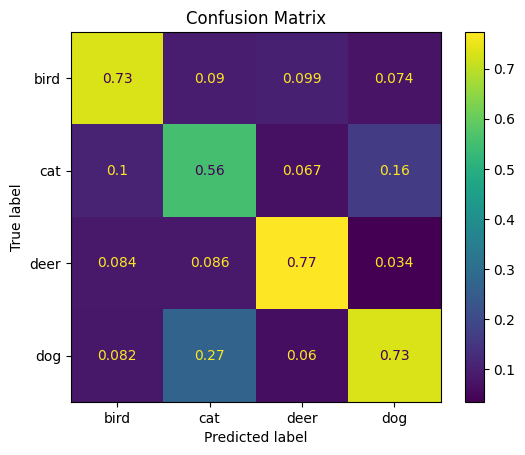

In [2]:
import tensorflow.keras as keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from clearml import Task, Logger
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

task = Task.init(project_name='vives-mlops-workshop', task_name='exercise7', output_uri=True)

# hyperparameters
config = {
    "conv1": 32,
    "conv2": 46,
    "conv3": 46,
    "dense1": 100,
}
task.connect(config)

# ---

# download the dataset
(images, labels), _ = keras.datasets.cifar10.load_data()

# there are 10 classes of images
all_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# choose four classes (feel free to change this!)
class_names = ["bird", "cat", "deer", "dog"]
print("Class names:", class_names)

# only keep images of these classes
class_indexes = [all_classes.index(c) for c in class_names]
to_keep = np.array([l in class_indexes for l in labels])
images = images[to_keep]
labels = labels[to_keep]

# change indexes from 10 to 2 classes
labels = np.array([class_indexes.index(l) for l in labels])

# normalize pixels between 0 and 1
images = images / 255.0

# split into train and test set
split = round(len(images) * 0.8)
train_images = images[:split]
train_labels = labels[:split]
test_images = images[split:]
test_labels = labels[split:]
print("Number of train images:", len(train_images))
print("Number of test images:", len(test_images))

# ---

# create neural network
model = keras.models.Sequential()
model.add(keras.Input(shape=(32, 32, 3)))

# convolutional layers
model.add(layers.Conv2D(config["conv1"], (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(config["conv2"], (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(config["conv3"], (3, 3), activation="relu"))

# add dense layers
model.add(layers.Flatten())
model.add(layers.Dense(config["dense1"], activation="relu"))
model.add(layers.Dense(4, activation="softmax"))

# ---

# compile and train the model
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10,
                    validation_data=(test_images, test_labels))

# ---

# report accuracy to ClearML
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
logger = Logger.current_logger()

for i in range(len(accuracy)):
    logger.report_scalar("training", "accuracy", accuracy[i], iteration=i)
    logger.report_scalar("training", "val_accuracy", val_accuracy[i], iteration=i)

# save model to disk
model.save("model.keras")

# show confusion matrix
test_predict = model.predict(test_images)
test_predict = np.argmax(test_predict, axis=1)
cm = confusion_matrix(test_labels, test_predict, normalize='pred')
ConfusionMatrixDisplay(cm, display_labels=class_names).plot()
plt.title("Confusion Matrix")
plt.show()

# report bad images
reported = 0
for i in range(len(test_labels)):
    if test_labels[i] != test_predict[i]:
        actual_class = class_names[test_labels[i]]
        predict_class = class_names[test_predict[i]]
        description = actual_class + " => " + predict_class
        logger.report_image("Bad images", description, iteration=reported, image=test_images[i])
        reported += 1
        if reported >= 10:
            break

# close ClearML task
task.close()